To Do List:
1. change the content of the intro
2. change the content of fine-tuning because is too general
3. comment properly all the code
4. add the vuldeepecker part
5. describe the tokenization pipeline
6. give a brief introduction of what the sast is

# Fine-tuning a LLM for Vulnerability Detection

Welcome to an exciting exploration of the future of static security analysis! \\
In this notebook, we investigate how large-language models (LLMs) can revolutionize traditional approaches that depend on syntax-based algorithms. By leveraging these cutting-edge AI technologies, we aim to uncover new possibilities for more robust, intelligent, and efficient security solutions. Can LLMs redefine the landscape of static analysis? Let's dive in and find out!

## What is static security analysis?

...

## What are large-language models?

Large language models are computational systems designed for natural language processing tasks, representing a pivotal step in AI evolution. This next wave of AI goes beyond task-specific models, focusing on systems trained on vast, unlabeled datasets that can adapt to diverse tasks with minimal effort. These versatile systems are called **foundation models**, a term popularized by the Stanford Institute for Human-Centered Artificial Intelligence, because they serve as the foundation for a wide range of applications. Using techniques like [self-supervised learning](https://arxiv.org/pdf/2110.09327) and [fine-tuning](https://arxiv.org/pdf/2002.06305), foundation models apply knowledge learned in one domain to another, achieving human-like generalization—albeit requiring far more data.
The transformative power of foundation models lies in the **transformer architecture**, introduced in the groundbreaking 2017 paper ['Attention is All You Need'](https://arxiv.org/pdf/1706.03762). This architecture serves as the backbone of advanced tools like *ChatGPT*, delivering cutting-edge performance across a wide range of AI applications. While initially developed for multilingual translation, transformers have since gained broader capabilities, enabling them to excel in diverse tasks.

Training large language models (LLMs) involves several key stages: pretraining, supervised fine-tuning, and the application of advanced techniques like reinforcement learning with human feedback (RLHF).

1. **Pretraining Stage**: In this phase, a large transformer model is trained on an enormous dataset, typically consisting of trillions of words scraped from the internet. The task here is self-supervised: the model learns to predict the next word in a given context, effectively "filling in the blanks." For example, given the input “The sky is ___”, the model predicts the most likely next word based on patterns in the data. Through this process, the model creates an internal representation of language, capturing statistical patterns and semantic relationships. Diverse training datasets allow these models to develop a broad understanding of the target language. However, the pretrained model is not yet optimized for specific tasks like sentiment analysis or text classification.

2. **Supervised Fine-Tuning Stage**: Fine-tuning builds on the general knowledge established during pretraining by adapting the model to specific tasks using labeled, task-specific datasets. For instance, a pretrained model can be fine-tuned for sentiment analysis by training it on a dataset of text labeled with sentiment categories. This phase significantly enhances the model's ability to perform specialized tasks, effectively transitioning it from a “jack-of-all-trades” to a “master of one”. This process, enables a model to apply knowledge from one domain to another. Fine-tuning is computationally less demanding compared to the resource-intensive pretraining phase, making it a practical and efficient way to optimize models for targeted applications.

Through this staged training process, foundation models achieve remarkable versatility and precision, demonstrating their potential to revolutionize natural language processing and beyond.

## How to use large-language models for static analysis?

We have seen that large-language models (LLMs) excel in various natural language tasks, but can they also be applied to static security analysis? In this context, the "language" in question is code. Although not the language of everyday conversations (except for programmers), code is still a structured and rule-based form of communication.

Interestingly, LLMs can work efficiently with a variety of programming languages, such as C, C++, C#, Python, and JavaScript. The goal is to leverage these models to uncover patterns in code that are difficult to detect using traditional methods, thereby enhancing the capabilities of static security analysis.

As discussed in the previous section, pretraining the model is essential to enable it to understand the patterns within a specific programming language. The model can be pretrained on multiple languages or just one, with a focus on a single language typically improving performance. However, this pretraining phase is resource-intensive, requiring significant computational power and data. Not everyone has the resources to perform this training, as the costs can run into the [thousands of dollars](https://arxiv.org/pdf/2004.08900), depending on the size of the model and dataset.

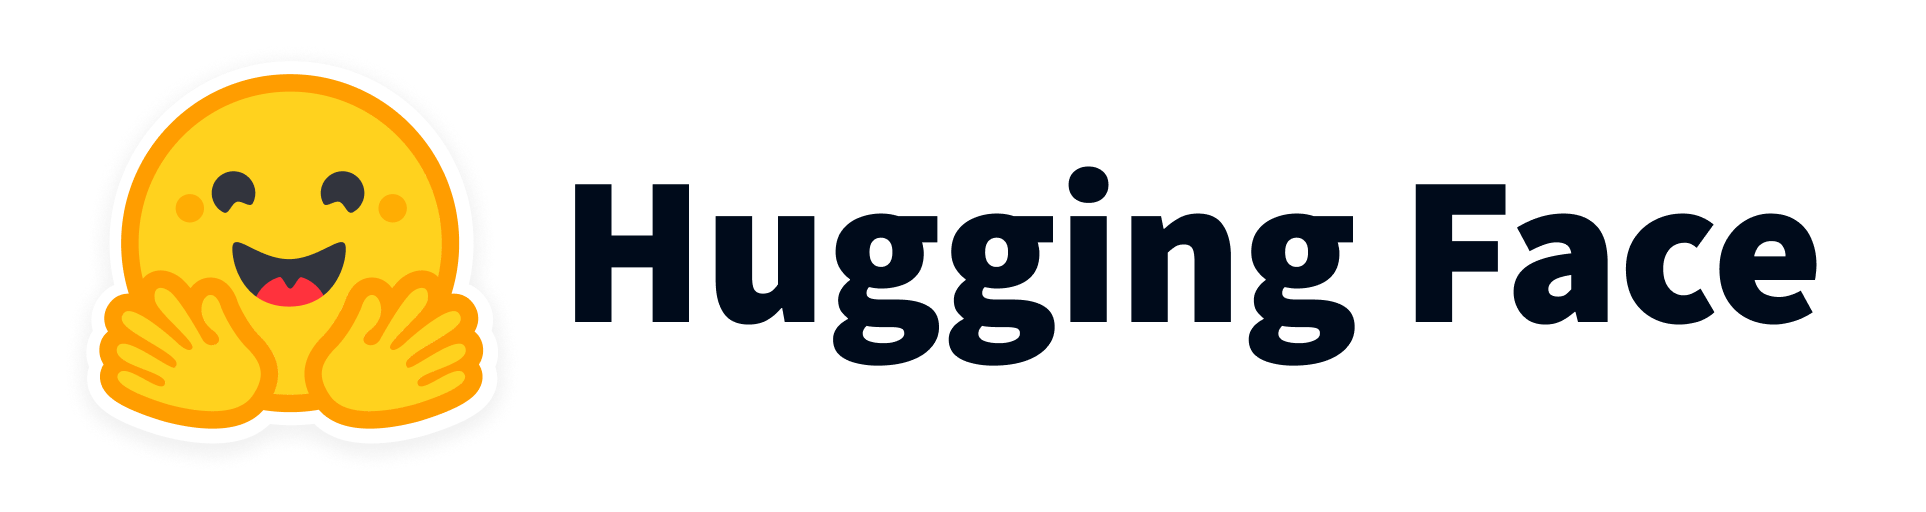

In [1]:
from huggingface_hub import notebook_login

notebook_login()

Luckily, the open-source community comes to the rescue. [Hugging Face](https://huggingface.co/) is one of the most widely used and comprehensive libraries for working with large-language models. You can import and upload very easly models and datasets, without the need to know exactly how they has been implemented.


In [2]:
!pip uninstall transformers -y

Found existing installation: transformers 4.47.0
Uninstalling transformers-4.47.0:
  Successfully uninstalled transformers-4.47.0


In [3]:
!pip install transformers==4.45.2 sentence-transformers==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 81.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 3.3.1
    Uninstalling sentence-transformers-3.3.1:
      Successfully uninstalled sentence-transformers-3.3.1


In [4]:
import torch # pytorch
import transformers # huggingface
import numpy as np # numpy
import json # json manager lib

In [5]:
print(transformers.__version__)

4.45.2


This means we can leverage a pretrained model on code, available on the Hugging Face Hub, and fine-tune it for our specific static analysis task. As discussed earlier, static analysis aims to identify code flaws within projects. However, large-language models have a limitation: they can only process inputs of a certain size. Since an entire project is often too large for the model, we need to divide it into smaller, more manageable units.

A commonly adopted granularity in the literature is **function-level detection**. Instead of analyzing an entire project or file, the model focuses on individual functions, treating them as standalone units **decontextualized** from the rest of the project. This approach enables efficient processing while still capturing meaningful patterns within the code.

Our ultimate goal in the next section will be to identify a suitable model and dataset to detect vulnerabilities within functions. The simplest task is a binary classification assessment, where the model predicts `1` for vulnerable and `0` for non-vulnerable functions. In this setup, the model simply determines whether a given function contains a vulnerability.

A possible improvement could involve leveraging the CWE (Common Weakness Enumeration) classification system to provide more detailed information about the type of vulnerability. Alternatively, we could enhance the task by localizing the vulnerability within the function's code itself.

## Model's selection

Hugging Face makes it easy to work with a wide range of open-source models published in the literature. These models share a common foundation based on the transformer architecture but differ in their variants and training strategies. For example, the [GPT-2](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) model (a predecessor of ChatGPT) is significantly different from BERT, both in architecture and training approach.

GPT-2 and its successors utilize the **Decoder** part of the transformer architecture, making them well-suited for tasks like *text generation* and *summarization*. On the other hand, BERT focuses on the **Encoder** side of the transformer, excelling in tasks such as *classification* and *understanding contextual relationships* in text.

Thus, the choice of model depends on the specific task to be performed, as each is optimized for different applications.

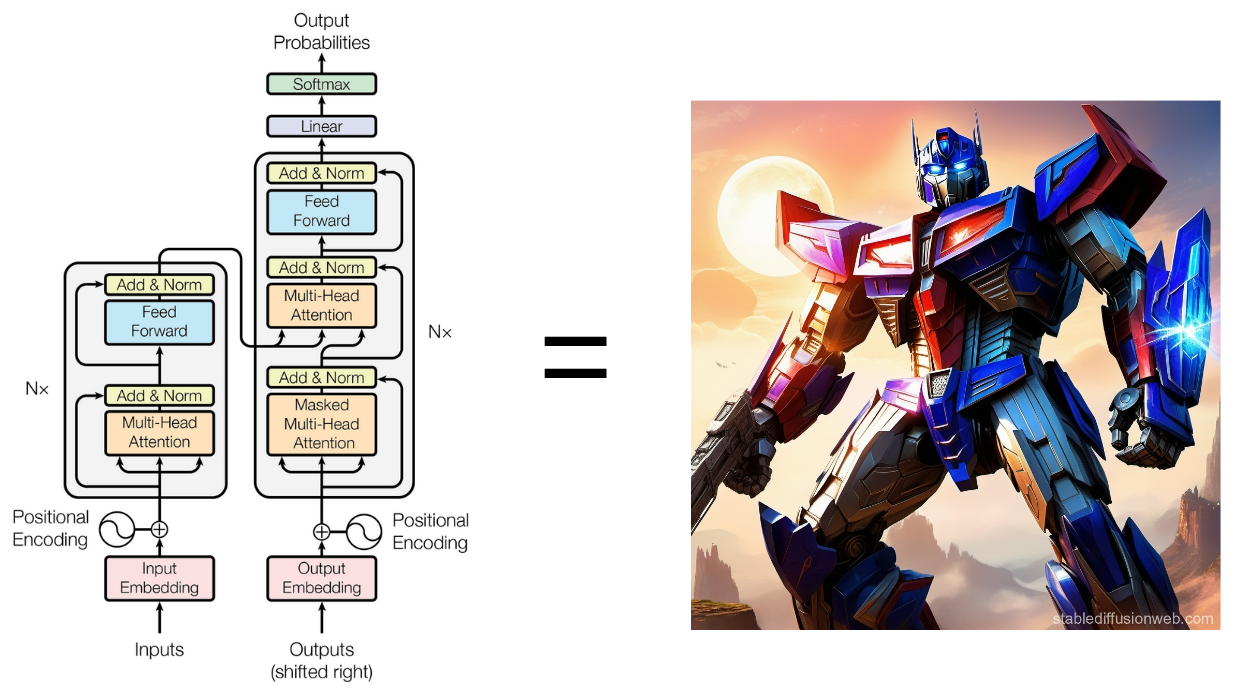

Returning to the context of code-based models, it is evident that using a pure BERT or GPT-2 model for fine-tuning a vulnerability detection task, while technically possible, is not the optimal choice. Instead, better results can be achieved by leveraging models specifically designed or pretrained for code analysis.

In the literature, several models are available for this purpose, including:

1. [CodeBERT](https://arxiv.org/pdf/2002.08155) (125M parameters): A BERT model specialized in code-based text.
2. [PolyCoder](https://arxiv.org/pdf/2202.13169) (160M parameters): A GPT-2 model specialized in code-based text.
3. [NatGen](https://arxiv.org/pdf/2206.07585) (220M parameters): A model in the T5 family (implemented using both Decoder and Encoder), specialized for code-related tasks.

These models are pretrained in various ways, and fine-tuning is required to use them effectively.

Fine-tuning is significantly less resource-intensive than pretraining an entire large language model from scratch. However, it is not always practical to fine-tune very large models, such as NatGen, due to their size and computational demands. Therefore, we will focus on fine-tuning the CodeBERT model. Specifically, I will use a modified version of CodeBERT, called [VulBERTa](https://arxiv.org/pdf/2205.12424), which is specialized for C++ code. VulBERTa has demonstrated superior performance in various benchmarks, such as [CodeGLUEX](https://microsoft.github.io/CodeXGLUE/) and [D2A](https://ibm.github.io/D2A/), making it a strong candidate for our task.

First of all, the Hugging Face Hub allows us to leverage the PyTorch library for easily fine-tuning large language models. As a first step, we need to define the device on which our model will be trained—preferably a GPU for faster and more efficient training!

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Next, we need to provide the Hugging Face library with all the necessary files required to import the model. I have uploaded the directory containing all the essential files to my drive, which can be accessed through this [link](https://onedrive.live.com/?authkey=%21AMp2R7BfDL%5Fnp9Y&id=15E206B36A9C8AE7%21300802&cid=15E206B36A9C8AE7&parId=root&parQt=sharedby&o=OneUp).

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Finally, we can import the VulBERTa model in local!

In [9]:
path_model_dir = './drive/MyDrive/VulBERTa'
vulberta = transformers.RobertaForSequenceClassification.from_pretrained(path_model_dir)
vulberta.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=1)
      (position_embeddings): Embedding(1026, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

We can observe that VulBERTa's structure includes a classifier head that is preconfigured for fine-tuning on vulnerability detection tasks. By default, this classifier outputs two labels: `1` for vulnerable and `0` for non-vulnerable, as previously mentioned.

## What is the Tokenizer?

Large language models, as is well known, work with **words**. However, in a neural network, we can't directly process words; we process **numbers** instead. Therefore, we need a **parser** that can transform the text into numerical representations. This process is called **tokenization**, and it is divided into two main steps:

1. Divide the text into **subwords**: The tokenizer splits the text based on a predefined **vocabulary**, which contains all the subwords it recognizes.

2. Assign an **index** to each subword: Each subword is mapped to a specific index in a **lookup table**, which retrieves a **vector** (called an **embedding**) to serve as the actual input to the model.

The VulBERTa model uses a modified tokenizer, where step 1 described above is implemented using a **custom** function powered by the [Clang](https://libclang.readthedocs.io/en/latest/) library.

In [8]:
tokenizer_path = './drive/MyDrive/VulBERTa-Tokenizer'

In [9]:
### TOKENIZER

from clang import cindex

from tokenizers.pre_tokenizers import PreTokenizer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers import NormalizedString,PreTokenizedString
from typing import List

class MyTokenizer:

    cidx = cindex.Index.create()


    def clang_split(self, i: int, normalized_string: NormalizedString) -> List[NormalizedString]:
        ## Tokkenize using clang
        tok = []
        tu = self.cidx.parse('tmp.c',
                       args=[''],
                       unsaved_files=[('tmp.c', str(normalized_string.original))],
                       options=0)
        for t in tu.get_tokens(extent=tu.cursor.extent):
            spelling = t.spelling.strip()

            if spelling == '':
                continue

            ## Keyword no need

            ## Punctuations no need

            ## Literal all to BPE

            #spelling = spelling.replace(' ', '')
            tok.append(NormalizedString(spelling))

        return(tok)

    def pre_tokenize(self, pretok: PreTokenizedString):
        pretok.split(self.clang_split)

## Custom tokenizer

from tokenizers import Tokenizer
from tokenizers import normalizers,decoders
from tokenizers.normalizers import StripAccents, unicode_normalizer_from_str, Replace
from tokenizers.processors import TemplateProcessing
from tokenizers import processors,pre_tokenizers
from tokenizers.models import BPE

## Load pre-trained tokenizers
vocab, merges = BPE.read_file(vocab=f'{tokenizer_path}/drapgh-vocab.json', merges=f'{tokenizer_path}/drapgh-merges.txt')
my_tokenizer = Tokenizer(BPE(vocab, merges, unk_token="<unk>"))

my_tokenizer.normalizer = normalizers.Sequence([StripAccents(), Replace(" ", "Ä")])
my_tokenizer.pre_tokenizer = PreTokenizer.custom(MyTokenizer())
my_tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
my_tokenizer.post_processor = TemplateProcessing(
    single="<s> $A </s>",
    special_tokens=[
    ("<s>",0),
    ("<pad>",1),
    ("</s>",2),
    ("<unk>",3),
    ("<mask>",4)
    ]
)

## Which dataset to use for vulnerability detection

Choosing the right dataset is a complex task in machine learning. It needs to be precise and rich in samples to provide the model with sufficient knowledge for fully understanding the problem. In the context of vulnerability detection, constructing a dataset presents unique challenges, primarily because detecting vulnerabilities in code is not straightforward. Even for experts, identifying vulnerabilities can be neither immediate nor always possible due to the complexity of the code involved.

One major challenge is the time required to identify vulnerabilities within the code. Another significant limitation is that the analysis is often performed at the function level rather than across entire projects, as previously mentioned. This means that vulnerabilities triggered by interactions between multiple functions may not be fully captured by the model, which is a crucial limitation.

Fortunately, a significant number of vulnerabilities are typically found within individual functions, as highlighted in the following [publication](https://dl.acm.org/doi/pdf/10.1145/3533767.3534380) (*paragragh 3.2 Vulnerability Detection Granularity*). However, this observation depends on the specific project being analyzed, which underscores an important limitation of this approach.

Due to the time required to build databases for vulnerability detection, methodologies are commonly used to streamline the sample generation process. However, these approaches often result in imprecisions, such as missed vulnerabilities or false positives in the samples. For the same reason, it is uncommon to find vulnerability detection datasets that include detailed information about the type of vulnerability or its specific position within a function. Typically, the labels used are limited to the two categories employed in binary classification. This is the primary reason why the VulBERTa model outputs only two classes.

It's time to examine the available datasets, even if they are not perfect.

In [12]:
import pandas as pd

df = pd.DataFrame({
    "Datasets": ["VulDeePecker", "muVulDeePecker", "Draper", "D2A", "Reveal", "Devign", "BigVul", "CrossVul", "CVEFixes", "DiverseVul"],
    "#Functions": [42918, 181641, 1286262, 1295623, 18169, 26037, 264919, 134126, 168089, 330492],
    "#Vul_Functions": [14692, 43119, 87804, 18653, 1664, 11888, 11823, 6884, 8932, 18945],
    "%Vul_Functions": [34.2, 23.7, 6.8, 1.4, 9.2, 45.7, 4.5, 5.13, 5.31, 5.7],
    "#Vul_Functions_with_CWE": ["N/A", 43119, 87804, "N/A", "N/A", "N/A", 10895, 6833, 8343, 16109],
    "Type_Sample": ["synthetic", "synthetic", "mixed", "real-world", "real-world", "real-world", "real-world", "real-world", "real-world", "real-world"],
    "LabelingMethod": ["predefined pattern", "predefined pattern", "static analysers", "differential static analysis", "manual + commit code diff", "manual + commit code diff", "manual + commit code diff","manual + commit code diff", "manual + commit code diff", "manual + commit code diff"]
})
df.style \
  .format(precision=3, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1) \
  .relabel_index(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], axis=0)

,DATASETS,#FUNCTIONS,#VUL_FUNCTIONS,%VUL_FUNCTIONS,#VUL_FUNCTIONS_WITH_CWE,TYPE_SAMPLE,LABELINGMETHOD
1,VulDeePecker,42.918,14.692,"34,200",N/A,synthetic,predefined pattern
2,muVulDeePecker,181.641,43.119,"23,700",43.119,synthetic,predefined pattern
3,Draper,1.286.262,87.804,"6,800",87.804,mixed,static analysers
4,D2A,1.295.623,18.653,"1,400",N/A,real-world,differential static analysis
5,Reveal,18.169,1.664,"9,200",N/A,real-world,manual + commit code diff
6,Devign,26.037,11.888,"45,700",N/A,real-world,manual + commit code diff
7,BigVul,264.919,11.823,"4,500",10.895,real-world,manual + commit code diff
8,CrossVul,134.126,6.884,"5,130",6.833,real-world,manual + commit code diff
9,CVEFixes,168.089,8.932,"5,310",8.343,real-world,manual + commit code diff
10,DiverseVul,330.492,18.945,"5,700",16.109,real-world,manual + commit code diff


The ranking of these datasets is primarily based on three criteria: the "sample type," the "labeling method," and the presence of CWE information for the vulnerable functions. Based on this evaluation, it is evident that the [DiverseVul](https://arxiv.org/pdf/2304.00409) dataset is the best.

These datasets have  the following characteristics:

* VulDeePecker ...

* [Draper](https://ieeexplore.ieee.org/abstract/document/10427574) combines real-world and synthetic samples, with each function labeled using traditional static analysis tools, including [FlawFinder](https://dwheeler.com/flawfinder/), [CppCheck](https://cppcheck.sourceforge.io/), and [Clang](https://clang-analyzer.llvm.org/). However, this labeling methodology is not particularly reliable due to the [inaccuracy](https://dl.acm.org/doi/pdf/10.1145/3533767.3534380) of these tools.

* [D2A](https://arxiv.org/pdf/2102.07995) introduced a new labeling method called "differential static analysis." This approach involves:
  1. Collecting numerous commits that fix security vulnerabilities in reputable software projects.
  2. Applying traditional static analyzers (specifically Clang and Infer) both before and after the commit.
  3. If the analyzers show that the vulnerability has disappeared post-commit, the vulnerability is considered reliable. Otherwise, it is not regarded as genuine.

  While this method can automatically validate vulnerability-fix commits, it relies heavily on traditional SAST tools, leaving many vulnerabilities undetected. For AI models, these undetected labels pose significant challenges, making it preferable to work with commits labeled by issue trackers.

* [ReVeal](https://ieeexplore.ieee.org/abstract/document/9448435) is the first dataset that employs a state-of-the-art methodology involving manual annotation combined with commit code differences derived using standard issue trackers, such as [CVE](https://cve.mitre.org/). This approach improves labeling precision, but it still cannot guarantee that every modified function addresses the vulnerability. We can say that this dataset is like the "father" of more complete datasets, such as [BigVul](https://dl.acm.org/doi/pdf/10.1145/3379597.3387501), [CrossVul](https://dl.acm.org/doi/10.1145/3468264.3473122), and [CVEFixes](https://arxiv.org/pdf/2107.08760).

In the DiverseVul publication, the quality of a dataset was evaluated by analyzing 50 random samples from three state-of-the-art datasets—BigVul, CrossVul, and CVEFixes—as well as the union of these three datasets and DiverseVul itself. The commits were meticulously analyzed to determine the correctness of their labels. Three potential conditions leading to inaccurate labels were identified:

1. The vulnerability spans multiple functions, resulting in incorrect granularity of the sample.
2. The function itself is not vulnerable, but changes to it are relevant to fixing the vulnerability.
3. The function is neither vulnerable nor relevant to the vulnerability.

The percentages for these inaccuracies are detailed in the following table.

In [13]:
import pandas as pd

df = pd.DataFrame({
    "Dataset": ["DiverseVul", "CVEFixes ∪ BigVul ∪ CrossVul", "CVEFixes", "BigVul", "CrossVul"],
    "%Correct_Label": [60, 36, 51.7, 25, 47.8],
    "%Vulnerability_Spread_Across_Multiple_Functions": [10, 12, 10.3, 15.6, 13],
    "%Relevant_Consistency": [12, 12, 17.3, 9.4, 21.8],
    "%Irrelevant": [18, 40, 20.7, 50, 17.4]
})
df.style \
  .format(precision=3, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1) \
  .relabel_index(["1", "2", "3", "4", "5"], axis=0)

,DATASET,%CORRECT_LABEL,%VULNERABILITY_SPREAD_ACROSS_MULTIPLE_FUNCTIONS,%RELEVANT_CONSISTENCY,%IRRELEVANT
1,DiverseVul,"60,000","10,000","12,000","18,000"
2,CVEFixes ∪ BigVul ∪ CrossVul,"36,000","12,000","12,000","40,000"
3,CVEFixes,"51,700","10,300","17,300","20,700"
4,BigVul,"25,000","15,600","9,400","50,000"
5,CrossVul,"47,800","13,000","21,800","17,400"


DiverseVul has the **highest precision** among datasets, with only **60%** of labels being correct. Accurate labeling is crucial for machine learning, as inconsistencies can lead to incorrect results. While these datasets are not fully reliable, creating a definitive one would demand immense effort and expertise. For now, DiverseVul is the best option for studying and implementing AI models.

## Import and prepare the dataset

Now that we have chosen the dataset—even though it is not ideal—we need to settle for it. Otherwise, we would have to create the dataset ourselves (I dare you to try! 😄).

Anyway, the DiverseVul dataset is stored at the provided [link](https://drive.google.com/file/d/12IWKhmLhq7qn5B_iXgn5YerOQtkH-6RG/view). I have already uploaded it to the drive, so I just need to import it.

In [ ]:
path_dataset = './drive/MyDrive/diversevul.json'

dataset = []

with open(path_dataset, 'r') as file:
  for sample in file:
    dataset.append(json.loads(sample))

FileNotFoundError: [Errno 2] No such file or directory: './drive/MyDrive/diversevul.json'

Let's see what's inside one sample of the dataset.

In [ ]:
dataset[0]

We can see that the key 'func' countains the function in C/C++ decontsxualized from the project. However, we have to check the lengths of these functions, because our vulnerability detection model, as prevously said doesn't have infite disponibility for the input, so due to the fact that the input is limited to 1024 tokens.

In [ ]:
len(dataset)

In [ ]:
import matplotlib.pyplot as plt

def plot_ds_bars(dataset):
  num_vul = 0
  for sample in dataset:
    if sample['target'] == 1:
      num_vul += 1

  categories = ['Non-vulnerable', 'Vulnerable']
  values = [len(dataset) - num_vul, num_vul]

  plt.bar(categories, values)
  plt.ylabel('quantity')
  plt.title('dataset labels quantity')
  plt.show()

plot_ds_bars(dataset)

It is clear from the table above that the dataset is highly unbalanced. Therefore, we need to carefully select samples for the training and testing phases. During the fine-tuning process, we will allocate 80% of the data for training and 20% for testing. Additionally, we must account for the fact that the VulBERTa model cannot process functions longer than 1024 tokens, as this is the upper limit specified by the model's parameters. Consequently, the first challenge we must address is managing the length of the tokenized functions.

I will demonstrate a sample case where I calculate the length of an encoded function and add the necessary padding

In [ ]:
func1 = dataset[0]['func']
func1

This function is quite long. Let's check whether it falls within the range of 1024 tokens.

In [ ]:
len(my_tokenizer.encode(func1).ids)

Since `1043 > 1024`, we need to discard this function from the possible samples.

In [ ]:
func2 = dataset[1]['func']
func2

This second function is shorter, so let's tokenize it!

In [ ]:
ids_func2 = my_tokenizer.encode(func2).ids
len(ids_func2)

In this case, the function has the correct length. Now, we need to add padding so that each input sample has the same dimensions. Naturally, the padding tokens we add do not carry any specific meaning for the code we are processing.

In [ ]:
num_padding_tokens = 1024 - len(ids_func2)
num_padding_tokens

The number of padding tokens is `890`. Therefore, we need to create an array of this length filled with 1s and concatenate it sequentially with the token IDs of `func2`.

In [ ]:
input_func2 = np.concatenate((np.array(ids_func2), np.ones(num_padding_tokens)), axis=0)
input_func2, input_func2.shape

Adding padding to the functions using the numpy library is a straightforward process. In addition to the token ids, we need to say to the model which of these items is relevant for the evaluation. For this purpose we implement the attention mask.

In [ ]:
mask = np.array([1 for id in ids_func2])
attention_mask = np.concatenate((mask, np.zeros(num_padding_tokens)), axis=0)
attention_mask

The attention mask is a vector that assigns a value of 1 to tokens that are part of the sentence and 0 to padding tokens. This allows the model to focus on the sentence content and ignore the padding.

Now, imagine repeating this process for all the samples in our dataset, which is enormous (330,492 functions). It's a highly demanding task!

Unfortunately, the dataset preparation is still not complete. We need to divide it into training and testing sets, ensuring a balanced distribution of vulnerable and non-vulnerable functions. Notably, over 15,000 of the 18,945 vulnerable functions have fewer than 1024 tokens, whereas the number of non-vulnerable functions is significantly larger.

To address this, I decided to use a fixed percentage of vulnerable and non-vulnerable functions—8% for vulnerable and 92% for non-vulnerable—and split the data into 80% for training and 20% for testing. Due to the complexity of this preparation process, I'll outline only the steps involved, as my focus is on fine-tuning. The steps are as follows:

1. **Random Sampling**: Randomly sample from the non-vulnerable functions to create a dataset with 92% non-vulnerable and 8% vulnerable functions.
2. **Train-Test Split**: Randomly select 80% of the data for training and 20% for testing, maintaining the 92%-8% ratio for both vulnerable and non-vulnerable functions.
3. **Merge Groups**: Combine the two larger groups (80% non-vulnerable + 80% vulnerable) for the training set, and do the same for the testing set (20% non-vulnerable + 20% vulnerable).

Following this process, we obtain the final training and testing sets. I've uploaded these to my drive so they're ready for use.

In [8]:
path_diversevul_ds = './drive/MyDrive/diversevul'

with open(f'{path_diversevul_ds}/enc/train.json', 'r') as file:
  train_enc = json.load(file) # train encodings

with open(f'{path_diversevul_ds}/data/train.json', 'r') as file:
  train_data = json.load(file) # original train dataset

with open(f'{path_diversevul_ds}/enc/test.json', 'r') as file:
  test_enc = json.load(file) # test encodings

with open(f'{path_diversevul_ds}/data/test.json', 'r') as file:
  test_data = json.load(file) # original test dataset

These four instances are as follows:

1. `train_enc`: The training dataset containing all the token IDs of the functions.
2. `train_data`: The functions selected from DiverseVul for training, without any processing.
3. `test_enc`: The test dataset containing all the token IDs of the functions.
4. `test_data`: The functions selected from DiverseVul for testing, without any processing.

In [9]:
vul, nvul = 0, 0
for sample in train_data:
  if sample['target'] == 1:
    vul += 1
  else:
    nvul += 1

print(vul / (nvul + vul))

0.0792186797781072


We can confirm that the percentage is correct!

The final step in preparing the dataset is to generate the `Dataset`.

In [10]:
from torch.utils.data import Dataset

Upon the tokenized data, we have to match each sample with the correct label.

In [11]:
def process_labels(dataset):
  labels = []
  for sample in dataset:
    label = 0
    if sample['target'] == 1:
      label = 1
    labels.append(label)
  return labels

test_labels = process_labels(test_data)
train_labels = process_labels(train_data)

In [12]:
class VulnerabilityDetectiondDataset(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

In [13]:
test = VulnerabilityDetectiondDataset(encodings=test_enc, labels=test_labels)
train = VulnerabilityDetectiondDataset(encodings=train_enc, labels=train_labels)

In [14]:
train[0]

{'input_ids': tensor([    0, 38435, 42288,  ...,     1,     1,     1]),
 'attention_mask': tensor([1, 1, 1,  ..., 0, 0, 0]),
 'labels': tensor(0)}

Now, the dataset is finally really to be used for the fine-tuning process.

## Fine-tune the model

Due to the fact that the model has many parameters.

In [21]:
vulberta.num_parameters()

124836866

In terms of resources, we can't train the model as whole, but also a small part of it. In this case, I decided to train only the multi-player perceptron, which is the classifier of the VulBERTa model.

In [22]:
modules = [vulberta.roberta.embeddings, vulberta.roberta.encoder.layer[:5]]
for module in modules:
  for param in module.parameters():
    param.requires_grad = False

Another challenge to address is the imbalance in the dataset. One possible technique to handle this is using **class weights**. This approach assigns higher weights to the minority class, enabling the model to focus more on its patterns and reducing bias toward the majority class.

In [21]:
import sklearn
import torch.nn as nn

One possible implementation of this tecnique is by using the [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) library.

In [24]:
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=train_labels)
class_weights = torch.FloatTensor([class_weights[0], class_weights[1]])

In [25]:
class_weights

tensor([0.5430, 6.3116])

The class weights computed using this method need to be incorporated into the criterion, which is the loss function used for fine-tuning. In this case, since we are dealing with binary classification, it is convenient to use the [cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [26]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

The next step is to implement the actual training process. For transformer architectures, it is convenient to use the `Trainer` instance from the Hugging Face hub. The Transformers library provides a `Trainer` class to facilitate fine-tuning any of its pre-trained models on your dataset.

In [27]:
from transformers import Trainer, TrainingArguments

Since we are using a custom criterion, we need to modify the default `compute_loss` function of the `Trainer` to apply the class weights to the model.

In [28]:
class MyTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs["logits"]
    loss = criterion(logits, labels)
    return (loss, outputs) if return_outputs else loss

We need to define the arguments for our dataset in order to generate the appropriate training loop for our model.

In [29]:
seed = 42

In [30]:
training_args = TrainingArguments(
  output_dir='./drive/MyDrive/vulberta-mlp-diversevul', # where the model is saved
  overwrite_output_dir=False, # continue the training from the last checkpoint
  per_device_train_batch_size=16, # batch size
  num_train_epochs=10, # num epochs
  save_strategy='epoch', # save checkpoint at each epoch
  save_total_limit=20, # save last 20 checkpoints
  seed=seed, # seed to randomize the dataset
  learning_rate=2e-05, # initial step of the learning process
  fp16=True, # 16-bit floating point
  report_to='none', # don't generate report
  push_to_hub=True # save the model in the hub every epoch
)

In [31]:
trainer = MyTrainer(
  model=vulberta,
  args=training_args,
  train_dataset=train
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Finally, we can trigger our training loop!

In [32]:
trainer.train()

Step,Training Loss
500,0.295700
1000,0.348200
1500,0.344500
2000,0.364300
2500,0.371400
3000,0.384400
3500,0.380400
4000,0.365800
4500,0.400400
5000,0.387300


TrainOutput(global_step=93180, training_loss=0.23333484418762168, metrics={'train_runtime': 10369.3838, 'train_samples_per_second': 143.77, 'train_steps_per_second': 8.986, 'total_flos': 7.844971848824832e+17, 'train_loss': 0.23333484418762168, 'epoch': 10.0})

In [33]:
trainer.push_to_hub('End of training')

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/simonevigasio02/vulberta-mlp-diversevul/commit/c4ca864695dc3888ba4eafa112980f3765a72ac4', commit_message='End of training', commit_description='', oid='c4ca864695dc3888ba4eafa112980f3765a72ac4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/simonevigasio02/vulberta-mlp-diversevul', endpoint='https://huggingface.co', repo_type='model', repo_id='simonevigasio02/vulberta-mlp-diversevul'), pr_revision=None, pr_num=None)

## How to calculate the effectiveness of our model

I have loaded the model directly on my huggingface account, so I can use it directly from it.

In [15]:
mymodel = transformers.RobertaForSequenceClassification.from_pretrained('simonevigasio02/vulberta-mlp-diversevul')
mymodel.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/766 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=1)
      (position_embeddings): Embedding(1026, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

In [16]:
reveal_model_path = './drive/MyDrive/VB-MLP_reveal'
revealmodel = transformers.RobertaForSequenceClassification.from_pretrained(reveal_model_path)
revealmodel.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=1)
      (position_embeddings): Embedding(1026, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

In [17]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test, batch_size=1)

In [18]:
from tqdm.auto import tqdm # time bar

In [22]:
def evaluate(model):
  all_labels, all_preds = [], []
  model.eval()
  with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing Progress"):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      output = model(input_ids, attention_mask=attention_mask)
      probs = torch.nn.functional.softmax(output['logits'], dim=1)
      preds = torch.argmax(probs, dim=1).tolist()
      all_preds += preds
      all_labels += labels.tolist()

  confusion = sklearn.metrics.confusion_matrix(y_true=all_labels, y_pred=all_preds)
  tn, fp, fn, tp = confusion.ravel()
  print('tn', tn)
  print('fp', fp)
  print('fn', fn)
  print('tp', tp)
  print('Accuracy', str(sklearn.metrics.accuracy_score(y_true=all_labels, y_pred=all_preds)))
  print('Precision', str(sklearn.metrics.precision_score(y_true=all_labels, y_pred=all_preds)))
  print('Recall', str(sklearn.metrics.recall_score(y_true=all_labels, y_pred=all_preds)))
  print('F-measure', str(sklearn.metrics.f1_score(y_true=all_labels, y_pred=all_preds)))

In [23]:
evaluate(mymodel)

Testing Progress:   0%|          | 0/37299 [00:00<?, ?it/s]

tn 32681
fp 1660
fn 2018
tp 940
Accuracy 0.9013914582160379
Precision 0.36153846153846153
Recall 0.3177822853279243
F-measure 0.33825116948542644


In [24]:
evaluate(revealmodel)

Testing Progress:   0%|          | 0/37299 [00:00<?, ?it/s]

tn 31949
fp 2392
fn 2317
tp 641
Accuracy 0.8737499664870372
Precision 0.2113419057039235
Recall 0.21670047329276537
F-measure 0.21398764813887497
